In [1]:
import numpy as np
import scipy.stats
from scipy.stats import norm, truncnorm,binom
from scipy.io import loadmat
import importlib
import pickle
import sys
import os
sys.path.append('../code/')

import matplotlib.pyplot as plt

%matplotlib inline

from task_utils import action_num_to_str, state2idcs

In [2]:
save_stem='fireworld_1'

if not os.path.isdir('../saved_figures/'+save_stem):
    os.mkdir('../saved_figures/'+save_stem)

if not os.path.isdir('../saved_results/'+save_stem):
    os.mkdir('../saved_results/'+save_stem)

## Create tasks

In [3]:
import task_fire_world
importlib.reload(task_fire_world)
from task_fire_world import TaskFireWorld


In [4]:
task_1 = TaskFireWorld(order='C',nrows=5,ncols=7,
                      start_location=0,
                      fire_locations=[10,11,12,17,18,19],
                      goal_locations=[6],)

In [5]:
# nan marks start state, does not mean that the state has no rewards, just for easy printing

print(task_1)


[[  nan  -0.1  -0.1  -0.1  -0.1  -0.1   5. ]
 [ -0.1  -0.1  -0.1 -10.  -10.  -10.   -0.1]
 [ -0.1  -0.1  -0.1 -10.  -10.  -10.   -0.1]
 [ -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1]
 [ -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1]]


In [6]:
task_2 = TaskFireWorld(order='C',nrows=4,ncols=6,
                      start_location=0,
                      fire_locations=[4,8,11],
                      wall_locations=[7,13],
                      goal_locations=[16],)
print(task_2)

[[  nan  -0.1  -0.1  -0.1 -10.   -0.1]
 [ -0.1   0.  -10.   -0.1  -0.1 -10. ]
 [ -0.1   0.   -0.1  -0.1   5.   -0.1]
 [ -0.1  -0.1  -0.1  -0.1  -0.1  -0.1]]


In [7]:
task_3 = TaskFireWorld(order='C',nrows=4,ncols=5,
                      start_location=19,
                      fire_locations=[7,8,13],
                      #wall_locations=[7,13],
                      goal_locations=[2],)
print(task_3)

[[ -0.1  -0.1   5.   -0.1  -0.1]
 [ -0.1  -0.1 -10.  -10.   -0.1]
 [ -0.1  -0.1  -0.1 -10.   -0.1]
 [ -0.1  -0.1  -0.1  -0.1   nan]]


## Compute policies for task
Wrapper function which computes policies for certain tasks and saves results
Return dict with save paths

In [8]:
import time
import dp
importlib.reload(dp)
from dp import CVaR_DP
import mcmc_eval
importlib.reload(mcmc_eval)
from mcmc_eval import run_simulation, calc_V_CVaR_MCMC

def compute_policies(task,
                     task_name,
                     alpha_set,
                     alpha0_set, # needed for fCVaR
                     time_horizon=60,
                     gamma=0.9,
                     model_names=['pCVaR', 'nCVaR', 'fCVaR'],
                     verbose=True,
                     parallel=False,
                     ):

    save_stem = 'fireworld_1'
    # create folders for results if necessary
    if not os.path.isdir('../saved_figures/'+save_stem+ '/' + task_name):
        os.mkdir('../saved_figures/'+save_stem+ '/' + task_name)

    if not os.path.isdir('../saved_results/' +save_stem + '/' + task_name):
        os.mkdir('../saved_results/'+save_stem+ '/' + task_name)

    # keep track of save locations
    save_dict = {}
    # run for different models
    for model_name in model_names:
        print('Computing policies for {}'.format(model_name))
        start_time = time.time()
        # fCVaR needs extra treatment
        if model_name=='fCVaR':
            qs = []
            for alpha0 in alpha0_set:
                results = CVaR_DP(task, T=time_horizon, alpha0=alpha0, alpha_set=alpha_set, cvar_type=model_name,
                              gamma=0.9, verbose=True,parallel=True)
                qs.append(results['Q_CVaR'])
                print()

            results = {}
            results['Q_CVaR']= np.moveaxis(np.array(qs),0,-1)

        else:
            results = CVaR_DP(task, T=time_horizon, alpha_set=alpha_set, cvar_type=model_name,
                  gamma=gamma, verbose=verbose, parallel=parallel)
            print('policy shape', results['pi'].shape)

        savename= '../saved_results/'+save_stem+'/' + task_name + '/' + model_name+'_T='+str(time_horizon)+\
                      '_interpset='+str(len(interpolation_set))+'.p'
        # saving results
        pickle.dump(results, open(savename, "wb" ))
        save_dict[model_name] = savename

        time_taken = time.time() - start_time
        print('Policies Computed for {} in {} seconds'.format(model_name, time_taken))

    print('Finished successfully')
    return save_dict


### Define Hyperparameters

In [9]:
gamma = 0.9
time_horizon= 60

interpolation_set = np.array([0.        , 0.01      , 0.01274275, 0.01623777, 0.02069138,
                       0.02636651, 0.03359818, 0.04281332, 0.05455595, 0.06951928,
                       0.08858668, 0.11288379, 0.14384499, 0.18329807, 0.23357215,
                       0.29763514, 0.37926902, 0.48329302, 0.61584821, 0.78475997,
                       1.        ])


# choose a subset of alphas
#alpha0_i_set = [2,8,11,14,16,18,20]
##alpha0_i_set = [2,8,9,10,11,14,16,18,20]
alpha0_i_set = [0,2,8,11,14,16,18,20]
alpha0_set = [interpolation_set[i] for i in alpha0_i_set]
# make set if alphas smaller for fast computation
alpha_set = [interpolation_set[i] for i in alpha0_i_set]

### Run on Task

In [10]:

task_name =  'task_1'
#selected_task = task_2
#selected_task = task_3

In [65]:
path_dict = compute_policies(task=task_1, task_name='task_1', alpha_set=alpha_set, alpha0_set=alpha0_set, time_horizon=time_horizon, gamma=gamma)

Computing policies for pCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51


/home/nion/anaconda3/envs/env_twosteps/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0
59472
59472
0
Policies Computed for pCVaR in 1069.1295101642609 seconds
Computing policies for nCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0
118944
118944
0
Policies Computed for nCVaR in 525.6580471992493 seconds
Computing policies for fCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7


In [13]:
path_dict = compute_policies(task=task_2, task_name='task_2', alpha_set=alpha_set, alpha0_set=alpha0_set, time_horizon=time_horizon, gamma=gamma)

Computing policies for pCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49


/home/nion/anaconda3/envs/env_twosteps/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0
41300
41300
0
policy shape (25, 4, 8, 60)
Policies Computed for pCVaR in 576.6110138893127 seconds
Computing policies for nCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0
82600
82600
0
policy shape (25, 4, 8, 60)
Policies Computed for nCVaR in 330.7607669830322 seconds
Computing policies for fCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16

In [14]:
path_dict = compute_policies(task=task_3, task_name='task_3', alpha_set=alpha_set, alpha0_set=alpha0_set, time_horizon=time_horizon, gamma=gamma)

Computing policies for pCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0
117292
117292
0
policy shape (21, 4, 8, 60)
Policies Computed for pCVaR in 499.41498017311096 seconds
Computing policies for nCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41


/home/nion/anaconda3/envs/env_twosteps/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0
151984
151984
0
policy shape (21, 4, 8, 60)
Policies Computed for nCVaR in 283.87671661376953 seconds
Computing policies for fCVaR
t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0
151984
151984
0

t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48
t=47
t=46
t=45
t=44
t=43
t=42
t=41
t=40
t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0
151984
151984
0

t=59
t=58
t=57
t=56
t=55
t=54
t=53
t=52
t=51
t=50
t=49
t=48


## Generating Behavior Function

In [10]:
## Generating Behavior Function
import mcmc_eval
importlib.reload(mcmc_eval)
from mcmc_eval import run_simulation, calc_V_CVaR_MCMC

def generate_behavior(task, savename, alpha_set, alpha0_set, model_name='pCVaR', alpha0 = 1.0,invtemp = 10,Nsims=1000, gamma=0.9):

    # get the appropriate alpha
    alpha0_i = np.where(np.asarray(alpha_set)==alpha0)[0][0]
    # print(np.where(np.asarray(alpha0_set)==alpha0))
    # load Q-function
    results = pickle.load( open(savename, "rb" ) )

    # get the q-values
    Q = results['Q_CVaR']
    if model_name=='fCVaR':
        Q = Q[:,:,:,:,np.where(np.asarray(alpha0_set)==alpha0)[0][0]]

    # calculate policy using inverse temperature
    if invtemp=='max':
        policy = np.zeros_like(Q)
        for s in range(policy.shape[0]):
            for alph in range(policy.shape[2]):
                for t in range(policy.shape[3]):
                    maxQ_i = np.argmax(Q[s,:,alph,t])
                    policy[s,maxQ_i,alph,t] = 1.0
    else:
        policy = np.zeros_like(Q)
        denom = np.sum(np.exp(invtemp*Q[:,:,:,:]),axis=1)
        for a in range(4):
            policy[:,a,:,:] = np.exp(invtemp*Q[:,a,:,:]) / denom

    # generate behavior
    if model_name=='pCVaR':
        Xis=results['Xis']
        adjust_alpha=True
    else:
        Xis=None
        adjust_alpha=False

    # run the MCMC for the changing policy

    results_mcmc = run_simulation(task,
                                   policy,  # must be states x actions x alphas x time-steps
                                   gamma,
                                   T=time_horizon,
                                   Nsims = Nsims,
                                   s0 = task.start_location,
                                   alpha_i0= alpha0_i,
                                   alpha_set = alpha_set,
                                   Xis=Xis,
                                   adjust_alpha=adjust_alpha)

    return(results_mcmc, results)

## Plotting

In [11]:
import plotting
importlib.reload(plotting)
from plotting import plot_sa

## fCVaR

In [13]:
np.random.seed(1)
model_name='fCVaR'
alpha0=1.0
invtemp='max'
Nsims = 1000
#print(alpha_set)
#print(np.where(np.asarray(alpha_set)==alpha0))
alpha0_i = np.where(np.asarray(alpha_set)==alpha0)[0][0]
#print(alpha0_i)
print(alpha0_i_set)
save_stem_task = 'task_1'
savename= '../saved_results/'+save_stem+'/' + save_stem_task + '/' + model_name+'_T='+str(time_horizon)+\
          '_interpset='+str(len(interpolation_set))+'.p'


results_mcmc,_ = generate_behavior(task=task_1,
                                   savename=savename,
                                   alpha_set=alpha_set,
                                   alpha0_set=alpha0_set,
                                   model_name=model_name,
                                   alpha0 = alpha0,
                                   invtemp = invtemp,
                                   Nsims=Nsims)



[0, 2, 8, 11, 14, 16, 18, 20]
(array([7]),)


plot_q
embellish
add fire labels
add start labels
add goal
plot alpha
finished return fig


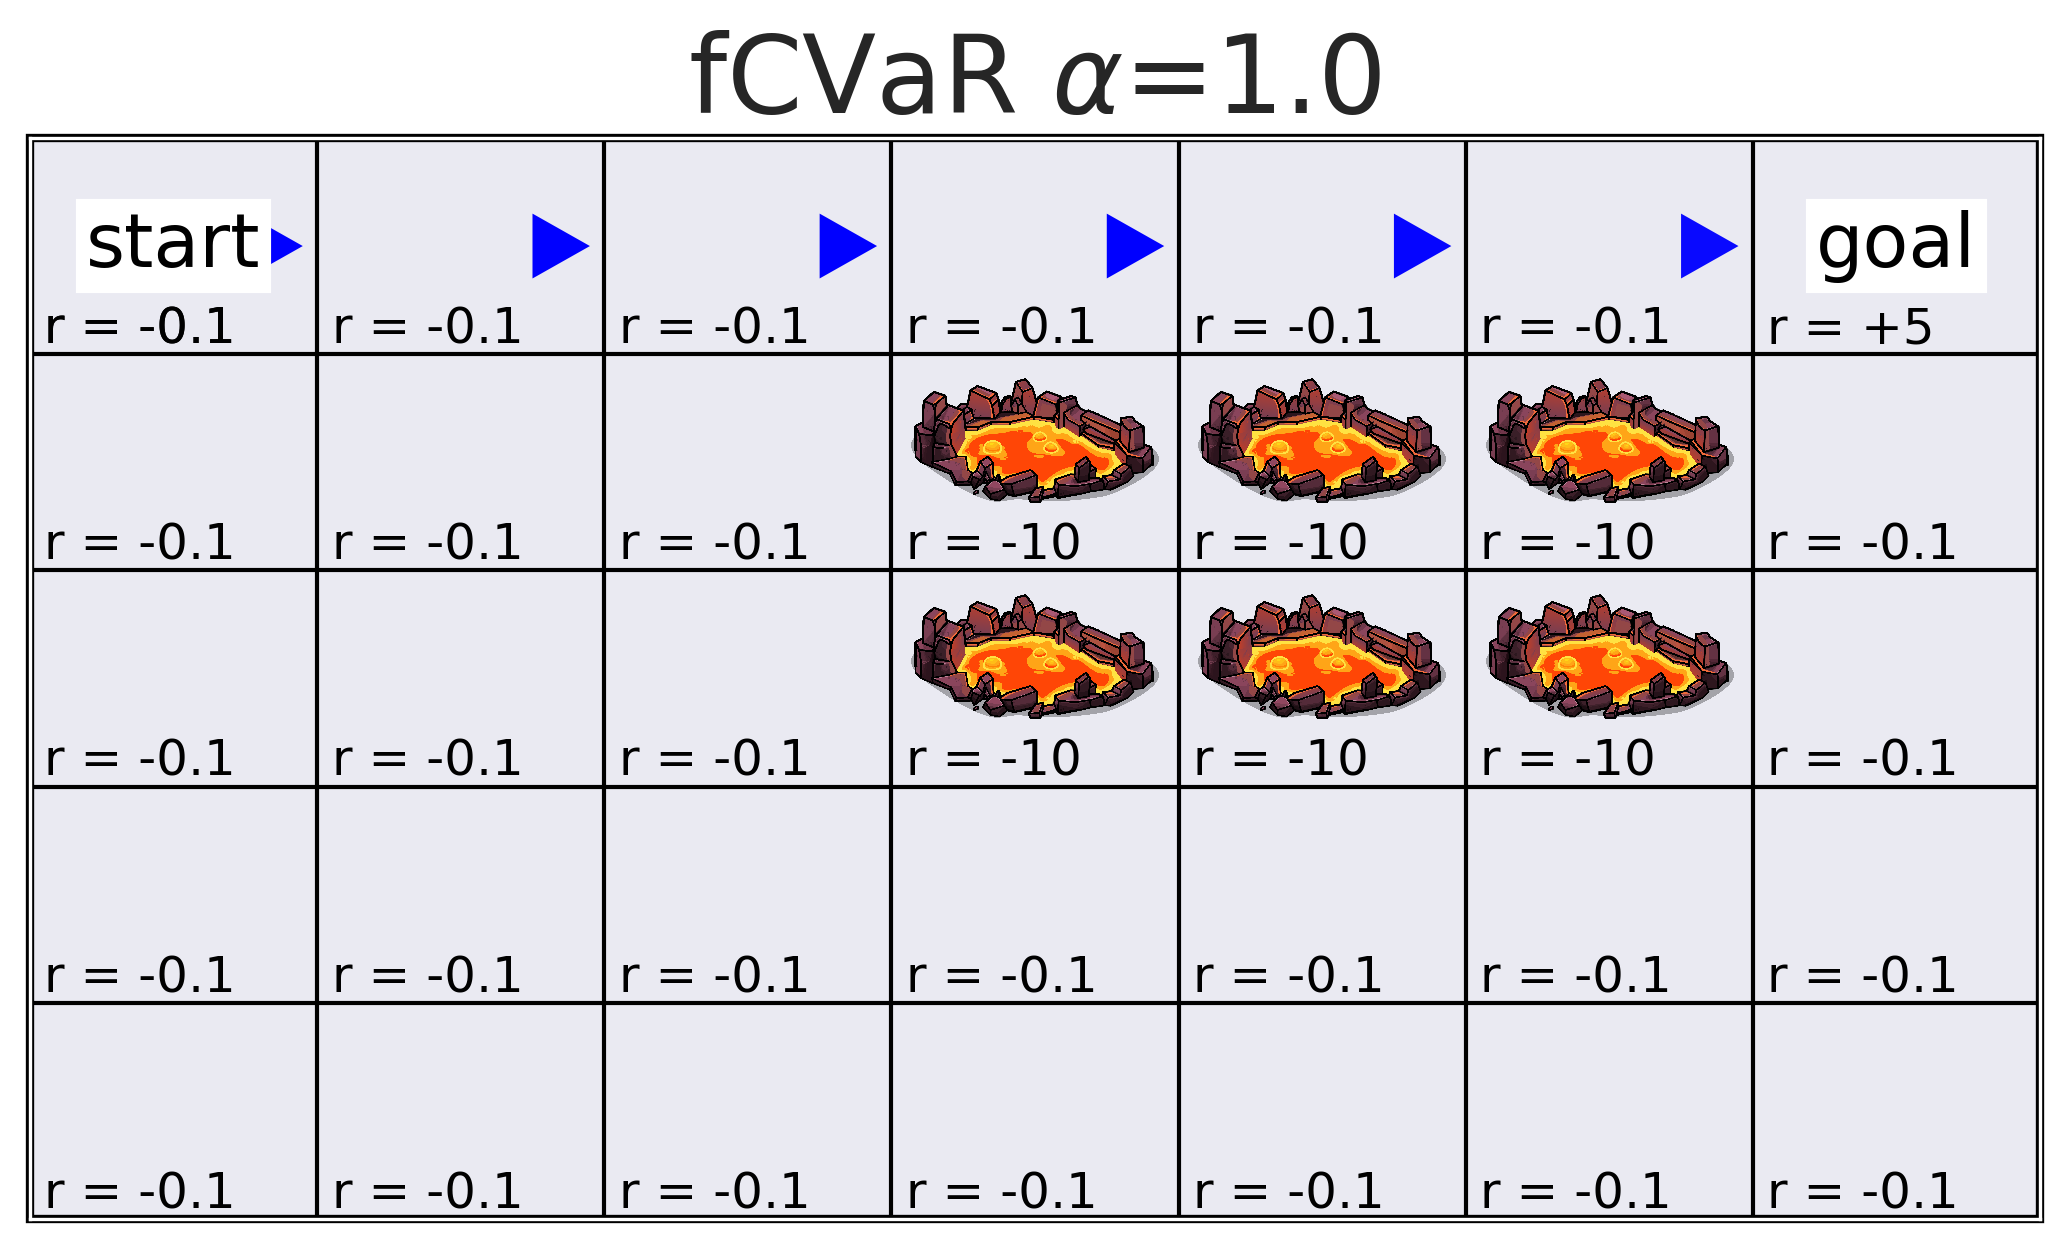

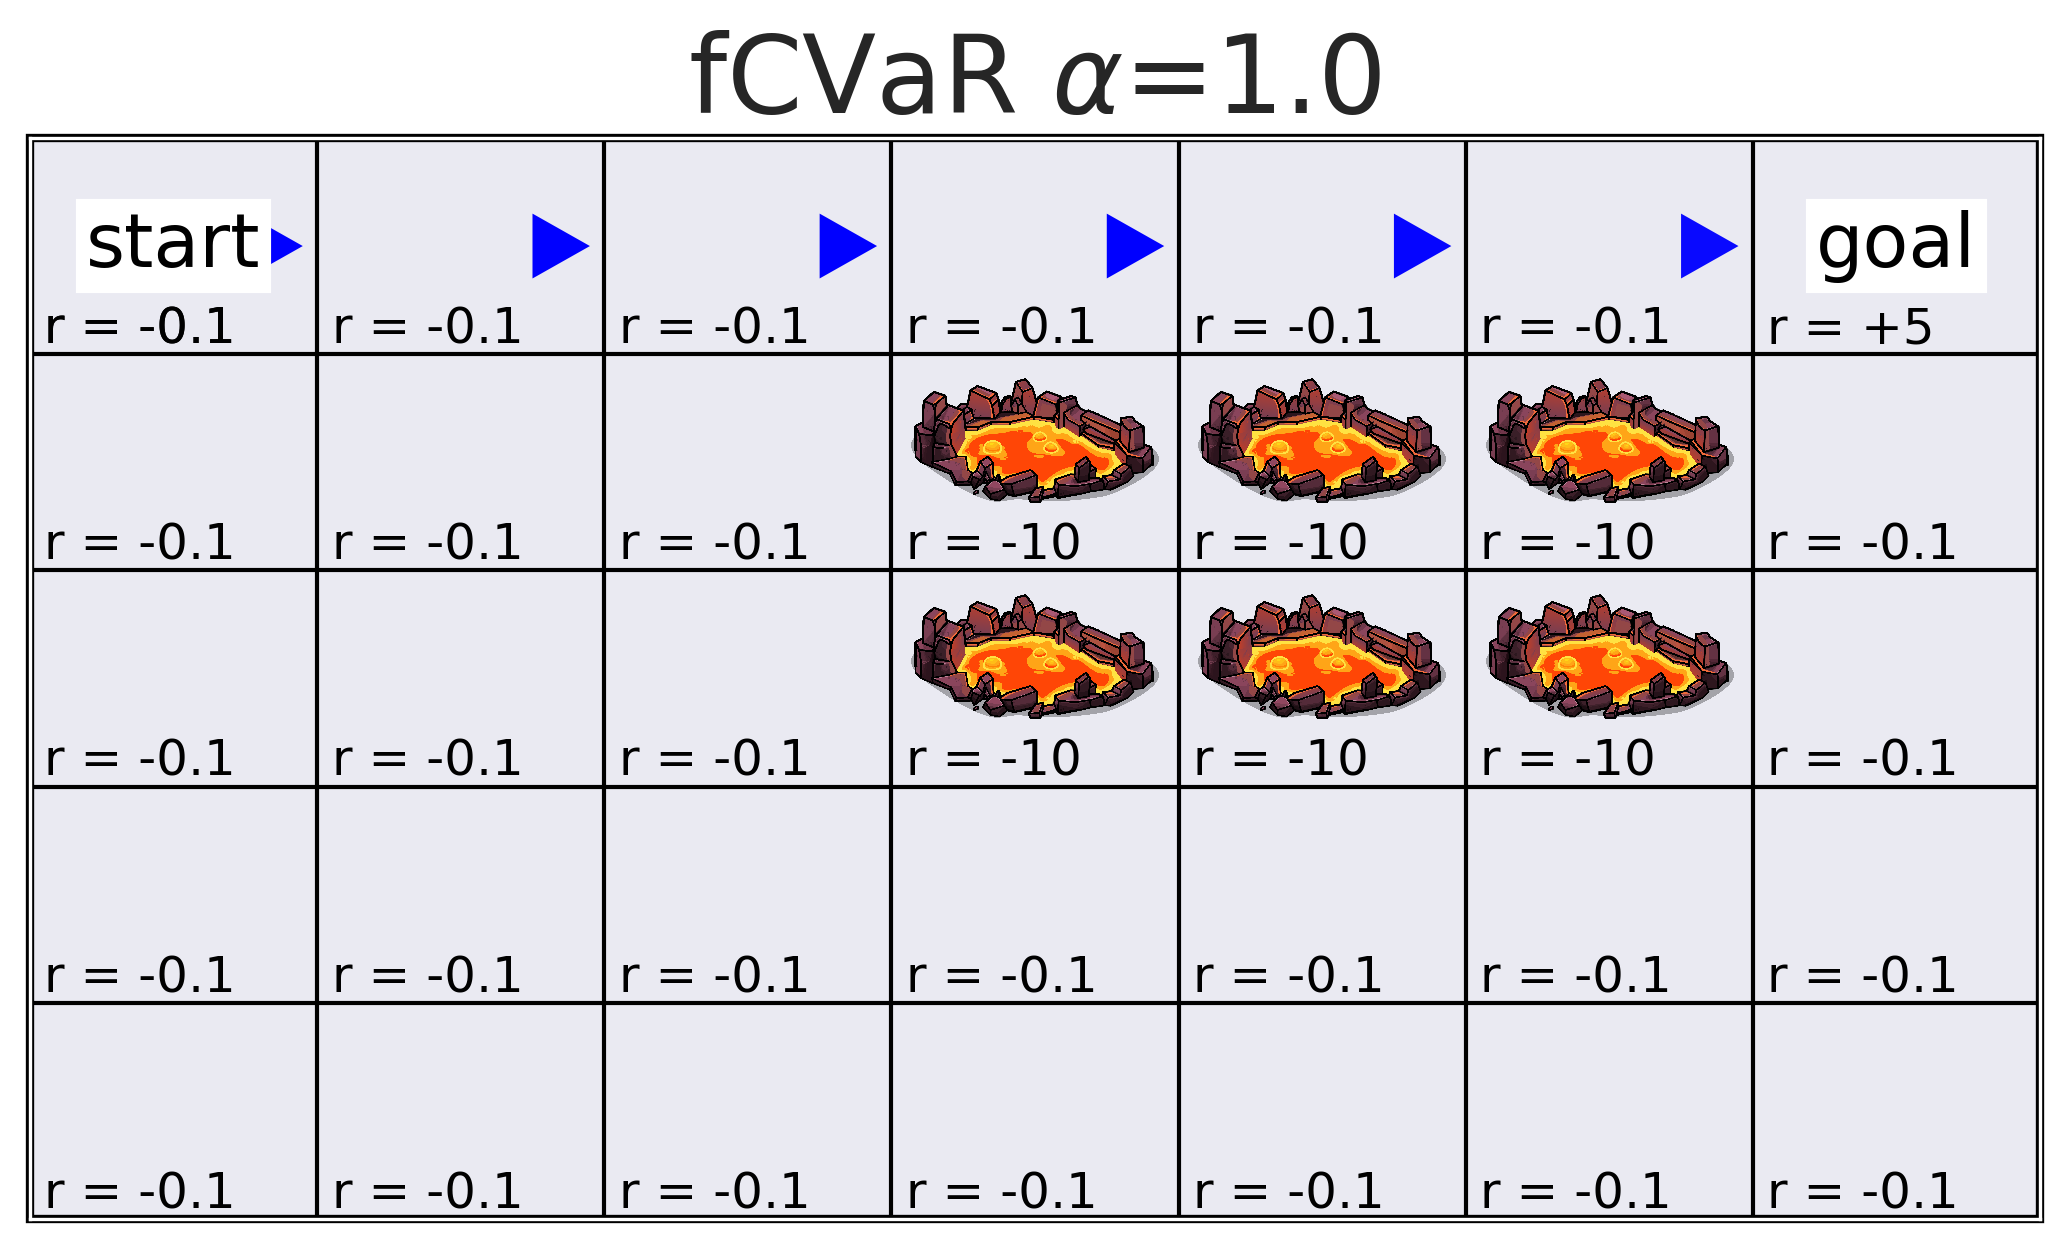

In [15]:
fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = sa_occupancy/Nsims

plot_sa(sa_occupancy,
        np.zeros(task.n_states-1),
        task,
        alpha_set,
        alpha0_i,
        model_name=model_name,
        q_or_pi='pi',
        fig=fig,
        ax=ax,
        finish=True,
        pi_color='blue',min_plot=0.05,title_fs=26,start_fs=18,reward_fs=12,show_alpha0=False)

### pCVaR

In [162]:
np.random.seed(1)
model_name='pCVaR'
alpha0=0.11288379
Nsims=1000
#alpha0_i = np.where(interpolation_set==alpha0)[0][0]
invtemp='max'
alpha0_i = np.where(np.asarray(alpha_set)==alpha0)[0][0]

save_stem_task = 'task_1'
savename= '../saved_results/'+save_stem+'/' + save_stem_task + '/' + model_name+'_T='+str(time_horizon)+\
          '_interpset='+str(len(interpolation_set))+'.p'

results_mcmc,_ = generate_behavior(task=task,
                                   savename=savename,
                                   alpha_set=alpha_set,
                                   alpha0_set=alpha0_set,
                                   model_name=model_name,
                                   alpha0 = alpha0,
                                   invtemp = invtemp,
                                   Nsims=Nsims)

(array([3]),)


In [163]:
sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = sa_occupancy/Nsims

In [164]:
med_alpha_per_state = []
mean_alpha_per_state = []
for s in range(task.n_states):
    med_alpha_per_state.append(np.median(results_mcmc['alphas'][results_mcmc['states']==s]))
    mean_alpha_per_state.append(np.mean(results_mcmc['alphas'][results_mcmc['states']==s]))
med_alpha_per_state=np.array(med_alpha_per_state)
mean_alpha_per_state=np.array(mean_alpha_per_state)

/home/nion/anaconda3/envs/env_twosteps/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nion/anaconda3/envs/env_twosteps/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [165]:
max_sa_occupancy = np.max(sa_occupancy, axis=1)  #[0:(task.Ns-1)]#.reshape(task.maze.shape)

med_alpha_per_state_masked = med_alpha_per_state[0:(task.n_states - 1)].copy()
med_alpha_per_state_masked[max_sa_occupancy <= 0.05] = 0.0

In [166]:
print(task.rewards)

[ -0.1  -0.1  -0.1  -0.1  -0.1  -0.1   5.   -0.1  -0.1  -0.1 -10.  -10.
 -10.   -0.1  -0.1  -0.1  -0.1 -10.  -10.  -10.   -0.1  -0.1  -0.1  -0.1
  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1  -0.1]


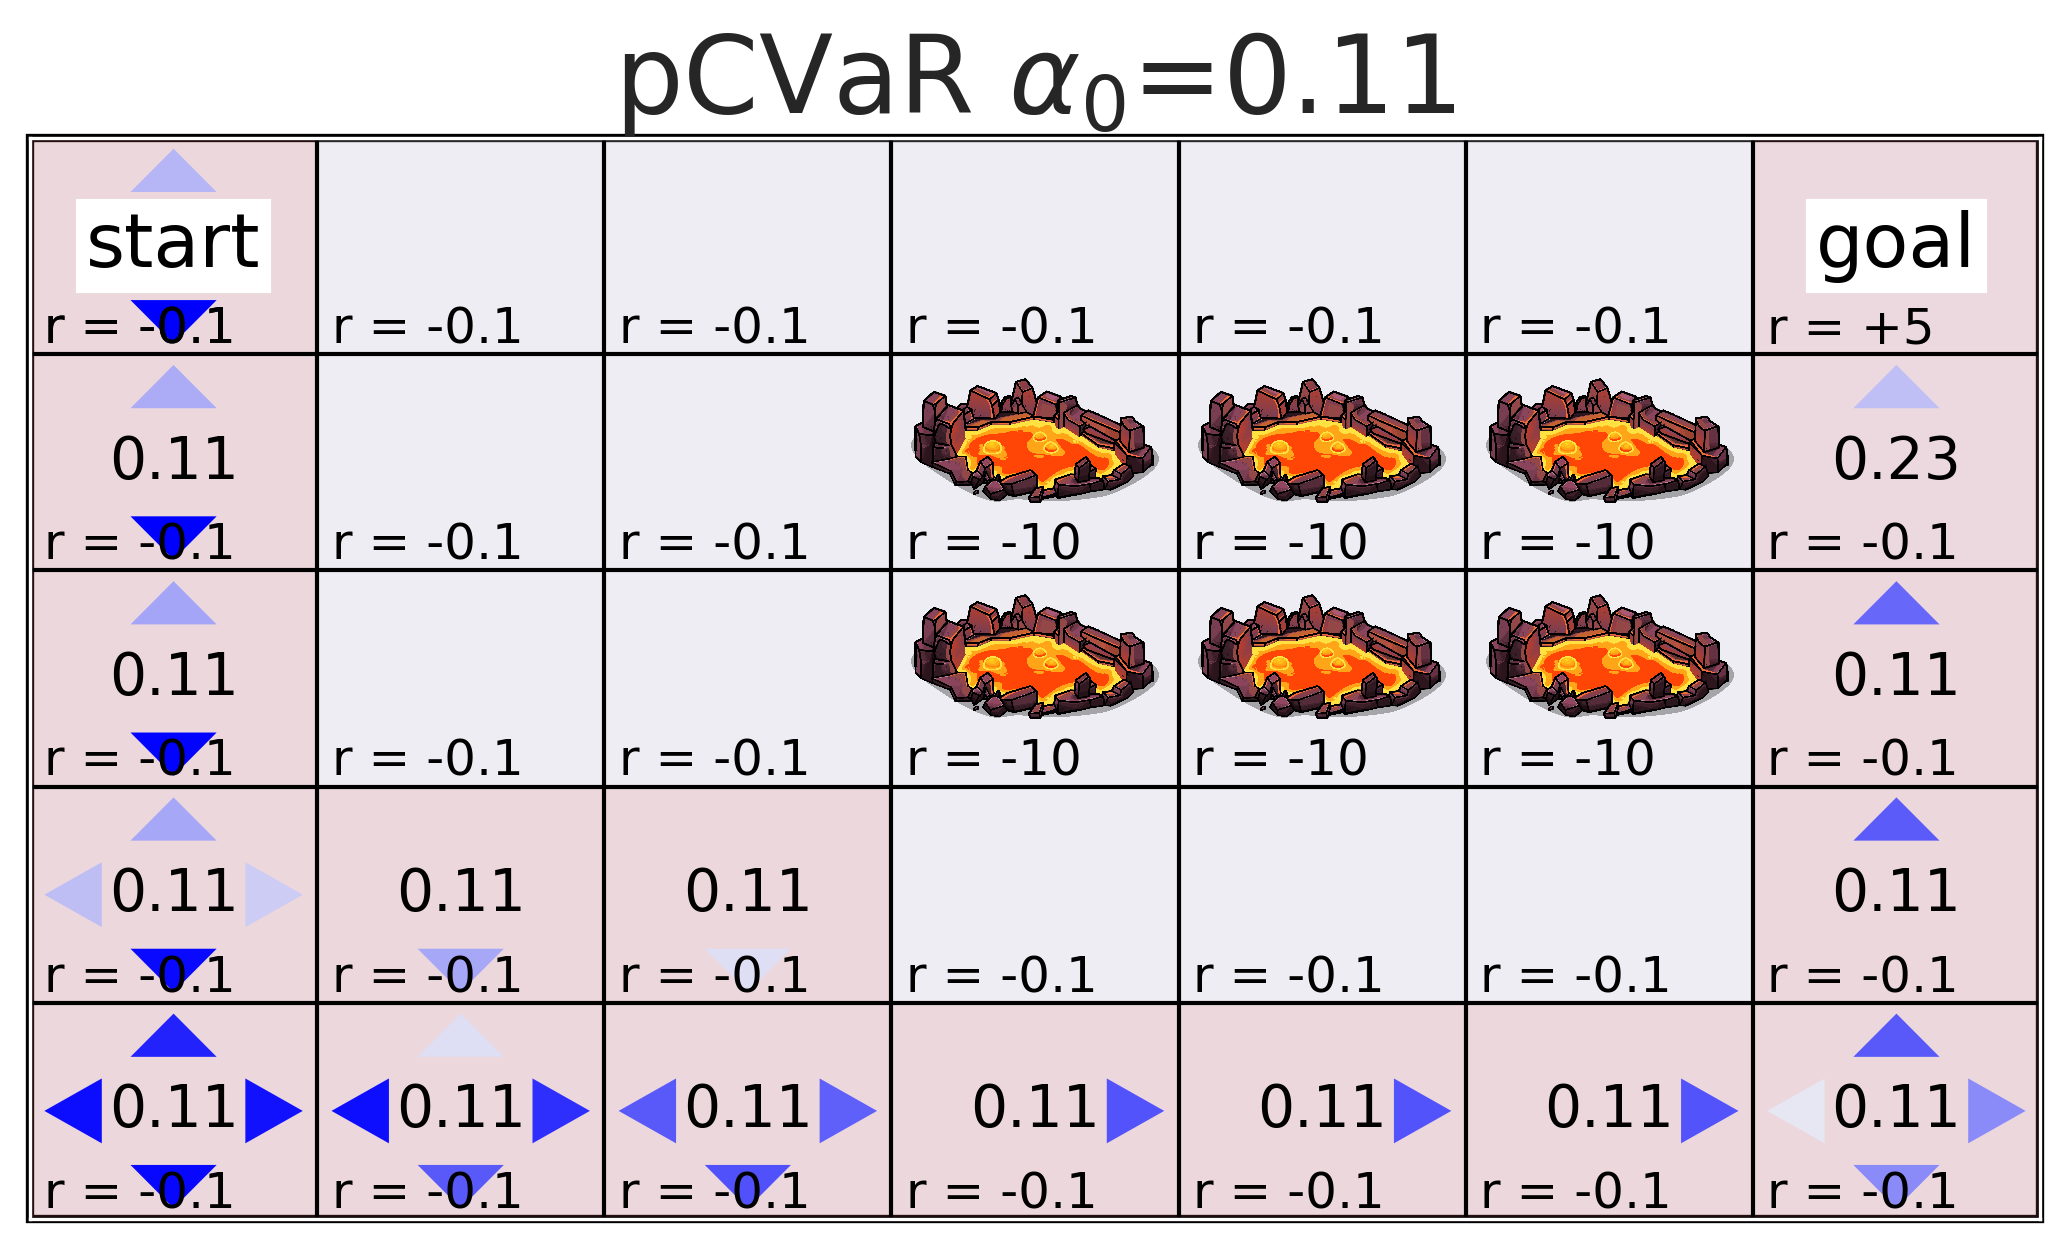

In [167]:
fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

plot_sa(sa_occupancy,
        med_alpha_per_state_masked, #np.round(med_alpha_per_state[0:(task.Ns-1)],2),
        task,
        alpha_set,
        alpha0_i,
        model_name=model_name,
        q_or_pi='pi',
        fig=fig,
        ax=ax,
        finish=True,
        pi_color='blue',
        min_plot=0.05,title_fs=26,start_fs=18,reward_fs=12,value_fs=14,show_alpha0=True)

In [159]:
print(alpha_set)

[0.0, 0.01274275, 0.05455595, 0.11288379, 0.23357215, 0.37926902, 0.61584821, 1.0]


In [12]:
def plot_task(task,
              task_name,
              alpha_set,
              alpha0_set,
              model_names=['pCVaR', 'nCVaR', 'fCVaR'],):
    # set seed
    np.random.seed(1)
    save_stem_task = task_name

    # iterate over models
    for model_name in model_names:

        for alpha in alpha_set:


            Nsims=1000
            invtemp='max'
            alpha0_i = np.where(np.asarray(alpha_set)==alpha)[0][0]


            savename= '../saved_results/'+save_stem+'/' + save_stem_task + '/' + model_name+'_T='+str(time_horizon)+\
            '_interpset='+str(len(interpolation_set))+'.p'
            #print(savename)

            print('Generating behavior for {} with alpha={}'.format(model_name, alpha))
            #print(task)
            results_mcmc,_ = generate_behavior(task=task,
                                               savename=savename,
                                               alpha_set=alpha_set,
                                               alpha0_set=alpha0_set,
                                               model_name=model_name,
                                               alpha0=alpha,
                                               invtemp = invtemp,
                                               Nsims=Nsims)
            #print('Finished Generating behavior')
            print('Plotting trajectories...')
            if model_name=='pCVaR':
                # special stuff for pcvar
                print(results_mcmc['first_sa_occup'].shape)
                sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1, :]
                sa_occupancy = sa_occupancy / Nsims
                med_alpha_per_state = []
                mean_alpha_per_state = []
                for s in range(task.n_states):
                    med_alpha_per_state.append(np.median(results_mcmc['alphas'][results_mcmc['states'] == s]))
                    mean_alpha_per_state.append(np.mean(results_mcmc['alphas'][results_mcmc['states'] == s]))
                med_alpha_per_state = np.array(med_alpha_per_state)
                mean_alpha_per_state = np.array(mean_alpha_per_state)
                max_sa_occupancy = np.max(sa_occupancy, axis=1)  #[0:(task.Ns-1)]#.reshape(task.maze.shape)
                print(max_sa_occupancy.shape)

                med_alpha_per_state_masked = med_alpha_per_state[0:(task.n_states - 1)].copy()
                med_alpha_per_state_masked[max_sa_occupancy <= 0.05] = 0.0

                fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

                print('starting plotting function')
                fig = plot_sa(sa_occupancy,
                        med_alpha_per_state_masked, #np.round(med_alpha_per_state[0:(task.Ns-1)],2),
                        task,
                        interpolation_set,
                        alpha0_i,
                        model_name=model_name,
                        q_or_pi='pi',
                        fig=fig,
                        ax=ax,
                        finish=True,
                        pi_color='blue',
                        min_plot=0.05,title_fs=26,start_fs=18,reward_fs=12,value_fs=14,show_alpha0=True)
            else:
                fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

                sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
                sa_occupancy = sa_occupancy/Nsims

                fig = plot_sa(sa_occupancy,
                        np.zeros(task.n_states-1),
                        task,
                        alpha_set,
                        alpha0_i,
                        model_name=model_name,
                        q_or_pi='pi',
                        fig=fig,
                        ax=ax,
                        finish=True,
                        pi_color='blue',min_plot=0.05,title_fs=26,start_fs=18,reward_fs=12,show_alpha0=False)
            # save plot
            # store plot for each alpha
            fig_savepath = '../saved_figures/' + save_stem+'/' + save_stem_task + '/' + model_name + '/' + 'alpha=' + str(alpha) + '.png'
            # make directory for each model
            if not os.path.isdir('../saved_figures/'+ save_stem + '/' + task_name + '/' + model_name):
                os.mkdir('../saved_figures/'+save_stem+ '/' + task_name + '/' + model_name)

            fig.savefig(fig_savepath, format='png')
            print('saved figure for {} with alpha: {} in'.format(model_name, alpha) + fig_savepath)




In [ ]:
plot_task(task=task_1, task_name='task_1', alpha_set=alpha_set, alpha0_set=alpha0_set)

Generating behavior for pCVaR with alpha=0.0
Plotting trajectories...
(1000, 21, 4)
(20,)
starting plotting function
plot_q
embellish


/home/nion/anaconda3/envs/env_twosteps/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nion/anaconda3/envs/env_twosteps/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


add fire labels
add start labels
add goal
plot alpha
finished return fig
saved figure for pCVaR with alpha: 0.0 in../saved_figures/fireworld_1/task_3/pCVaR/alpha=0.0.png
Generating behavior for pCVaR with alpha=0.01274275
Plotting trajectories...
(1000, 21, 4)
(20,)
starting plotting function
plot_q
embellish
add fire labels
add start labels
add goal
plot alpha
finished return fig
saved figure for pCVaR with alpha: 0.01274275 in../saved_figures/fireworld_1/task_3/pCVaR/alpha=0.01274275.png
Generating behavior for pCVaR with alpha=0.05455595
Plotting trajectories...
(1000, 21, 4)
(20,)
starting plotting function
plot_q
embellish
add fire labels
add start labels
add goal
plot alpha
finished return fig
saved figure for pCVaR with alpha: 0.05455595 in../saved_figures/fireworld_1/task_3/pCVaR/alpha=0.05455595.png
Generating behavior for pCVaR with alpha=0.11288379
Plotting trajectories...
(1000, 21, 4)
(20,)
starting plotting function
plot_q
embellish
add fire labels
add start labels
add go

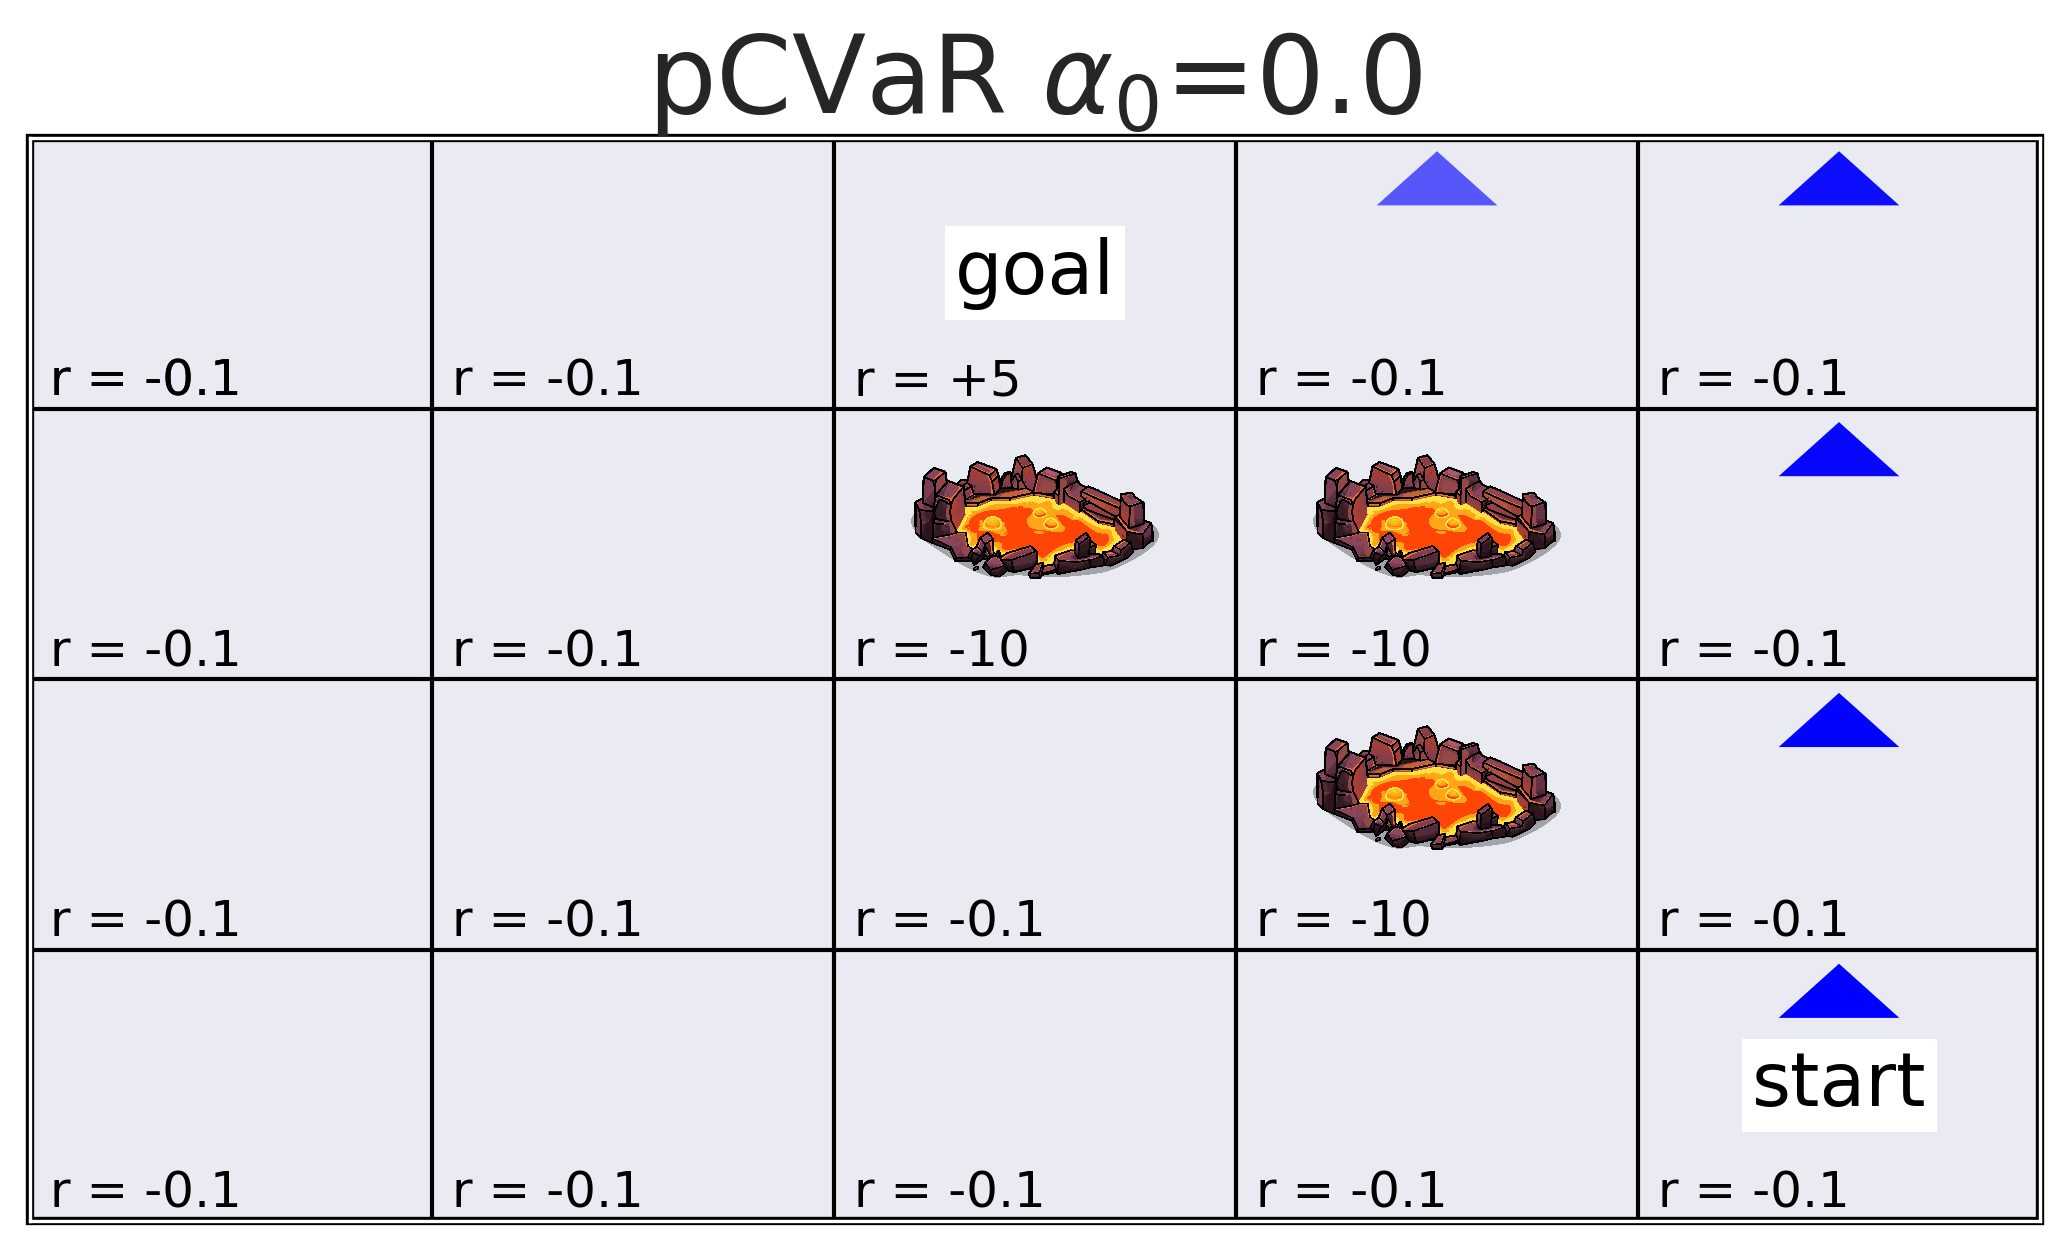

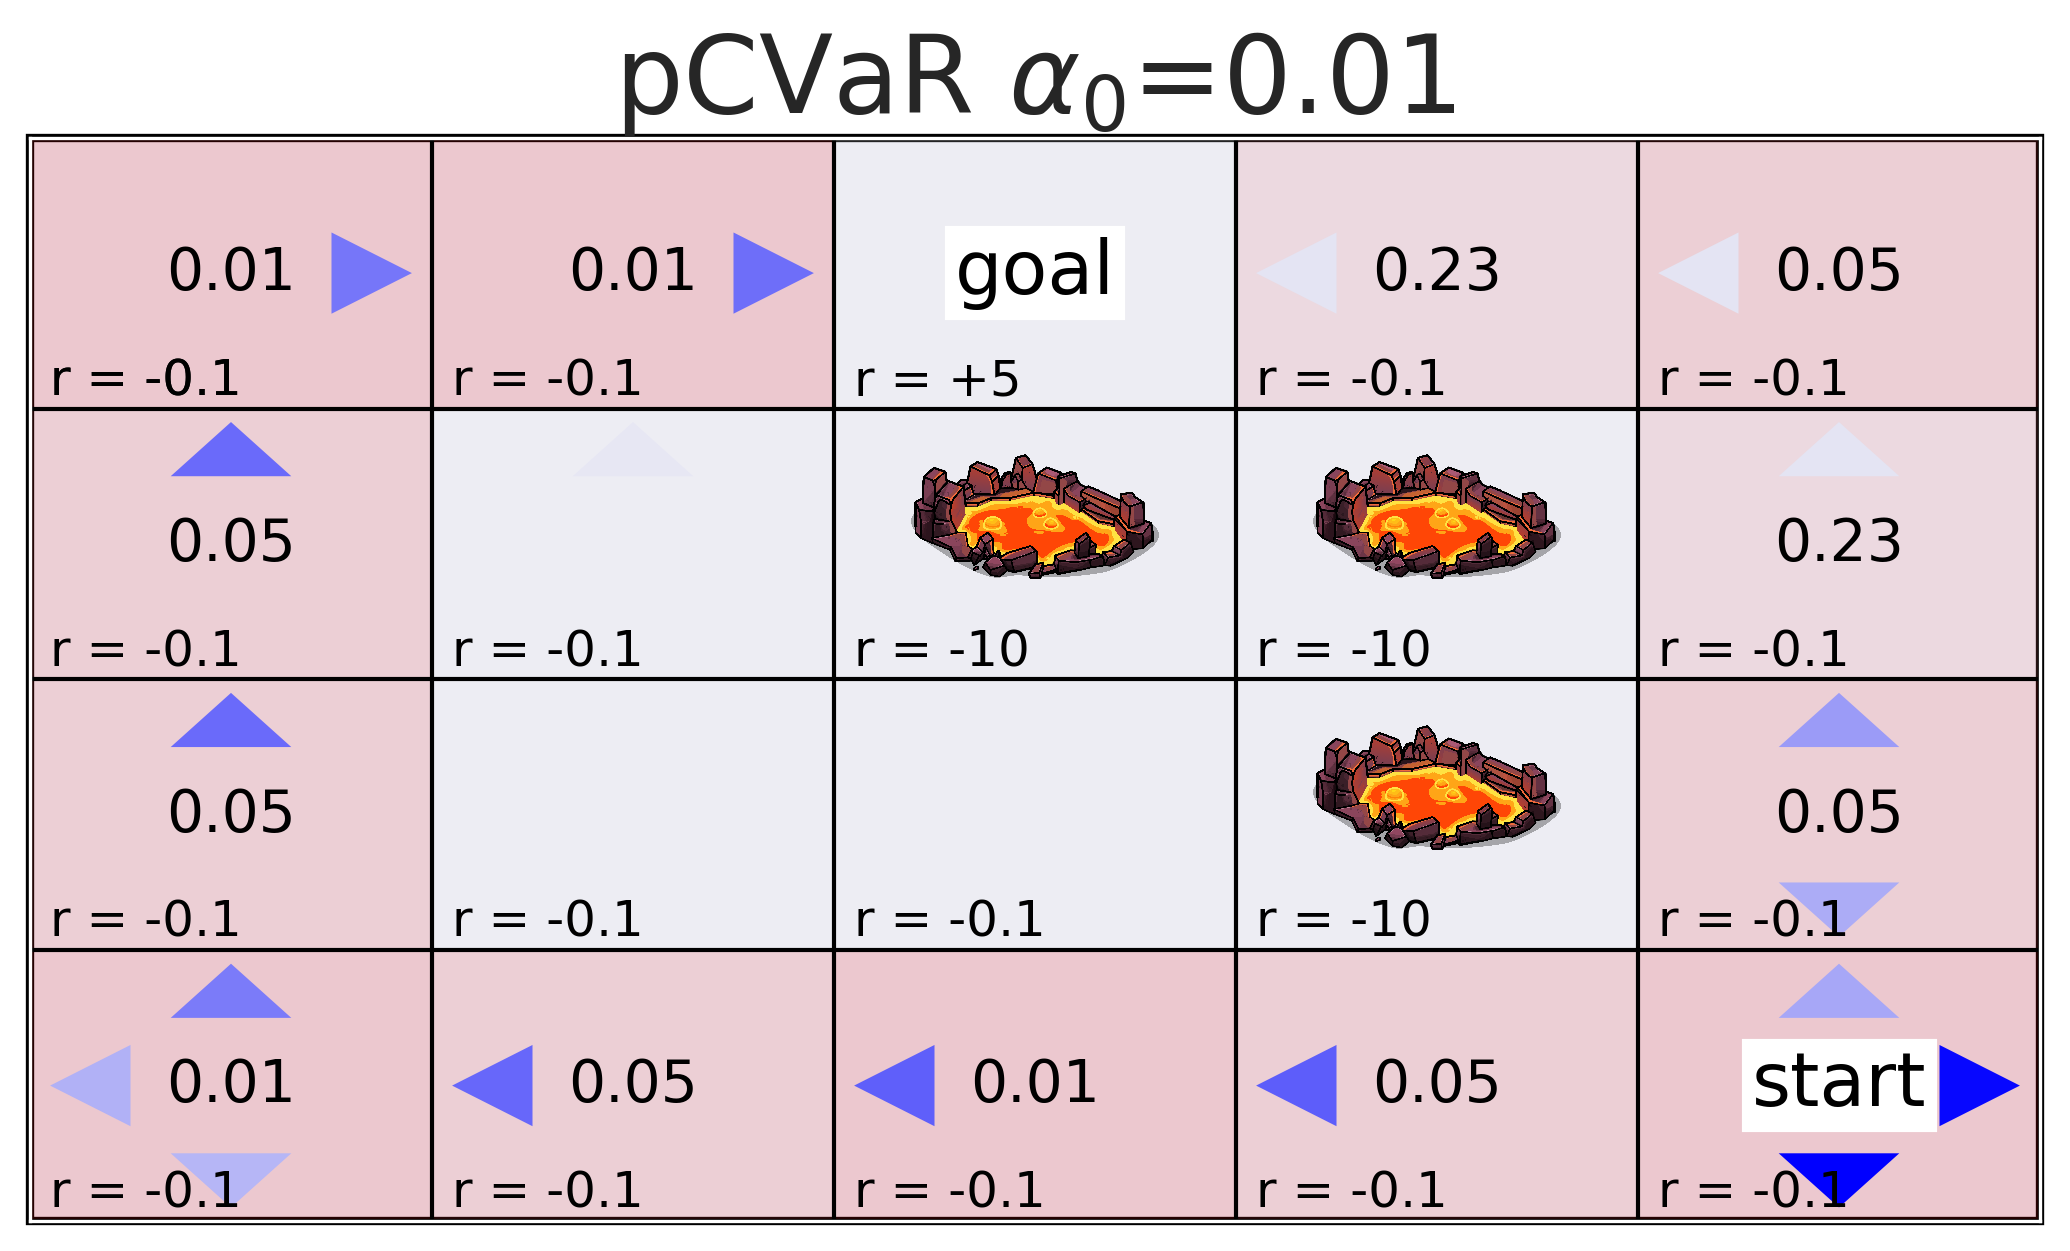

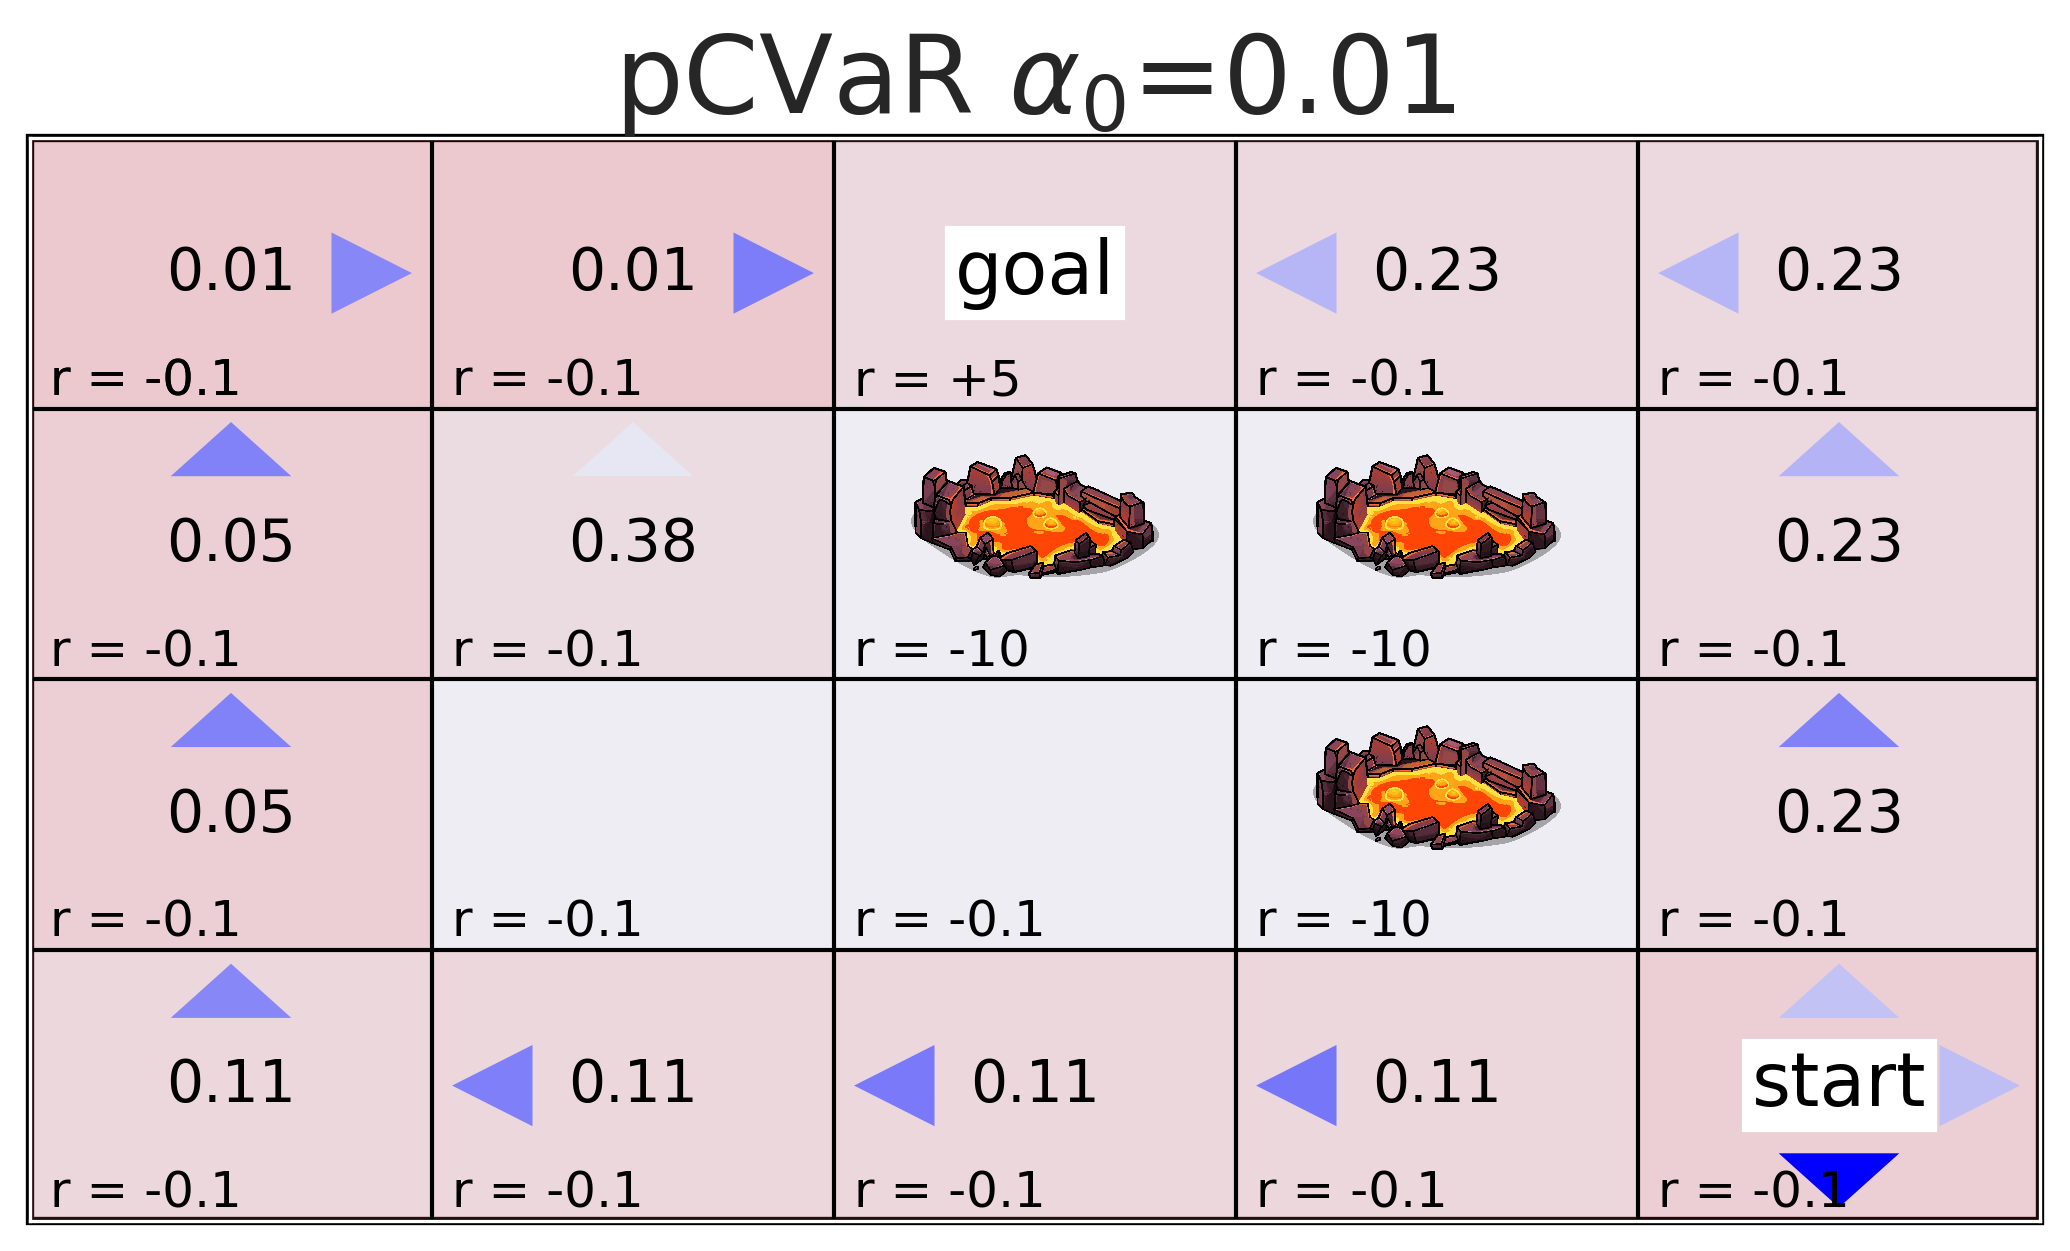

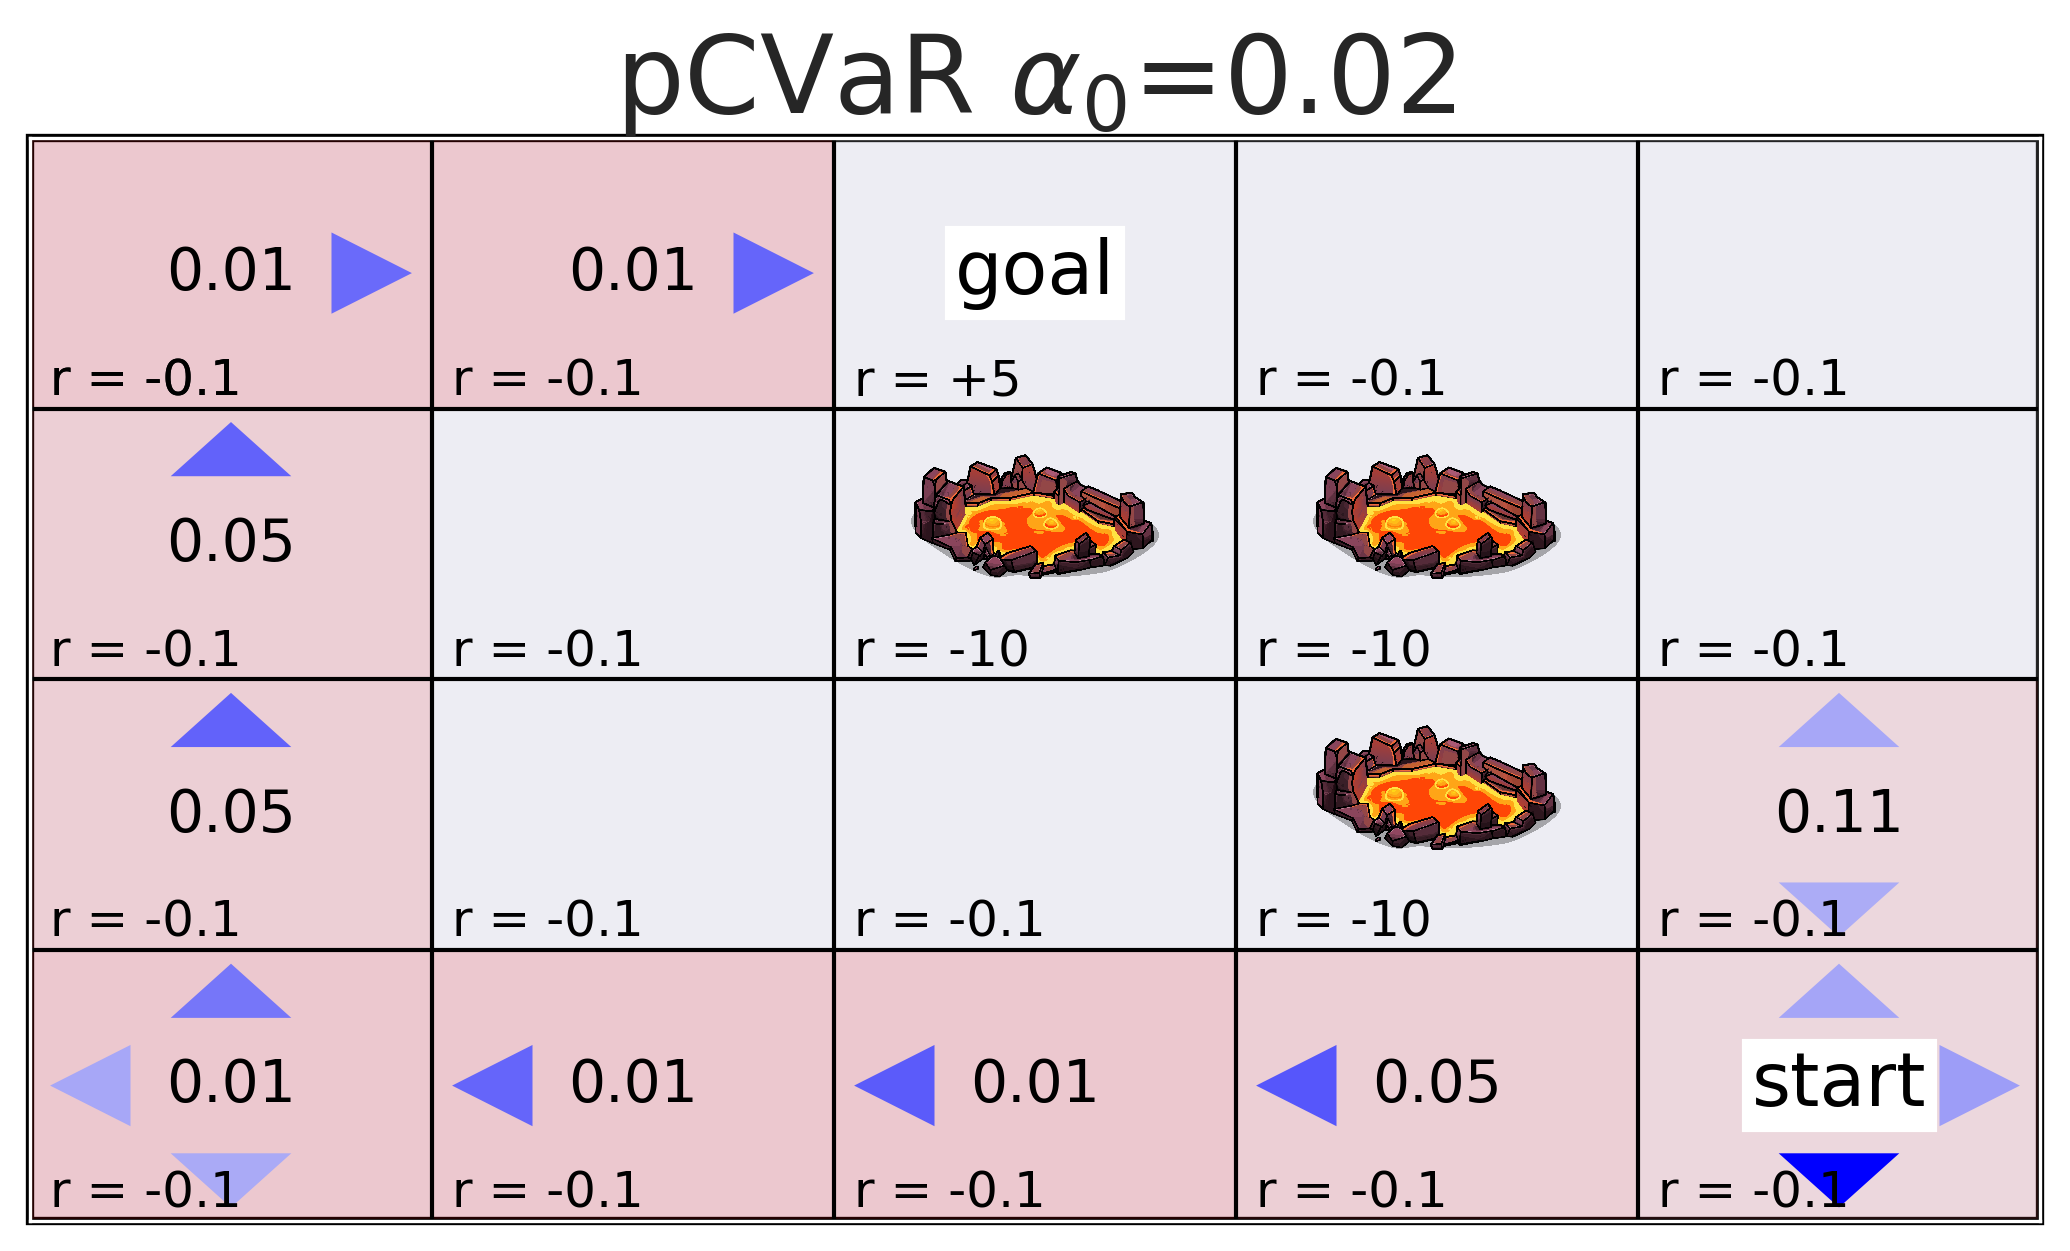

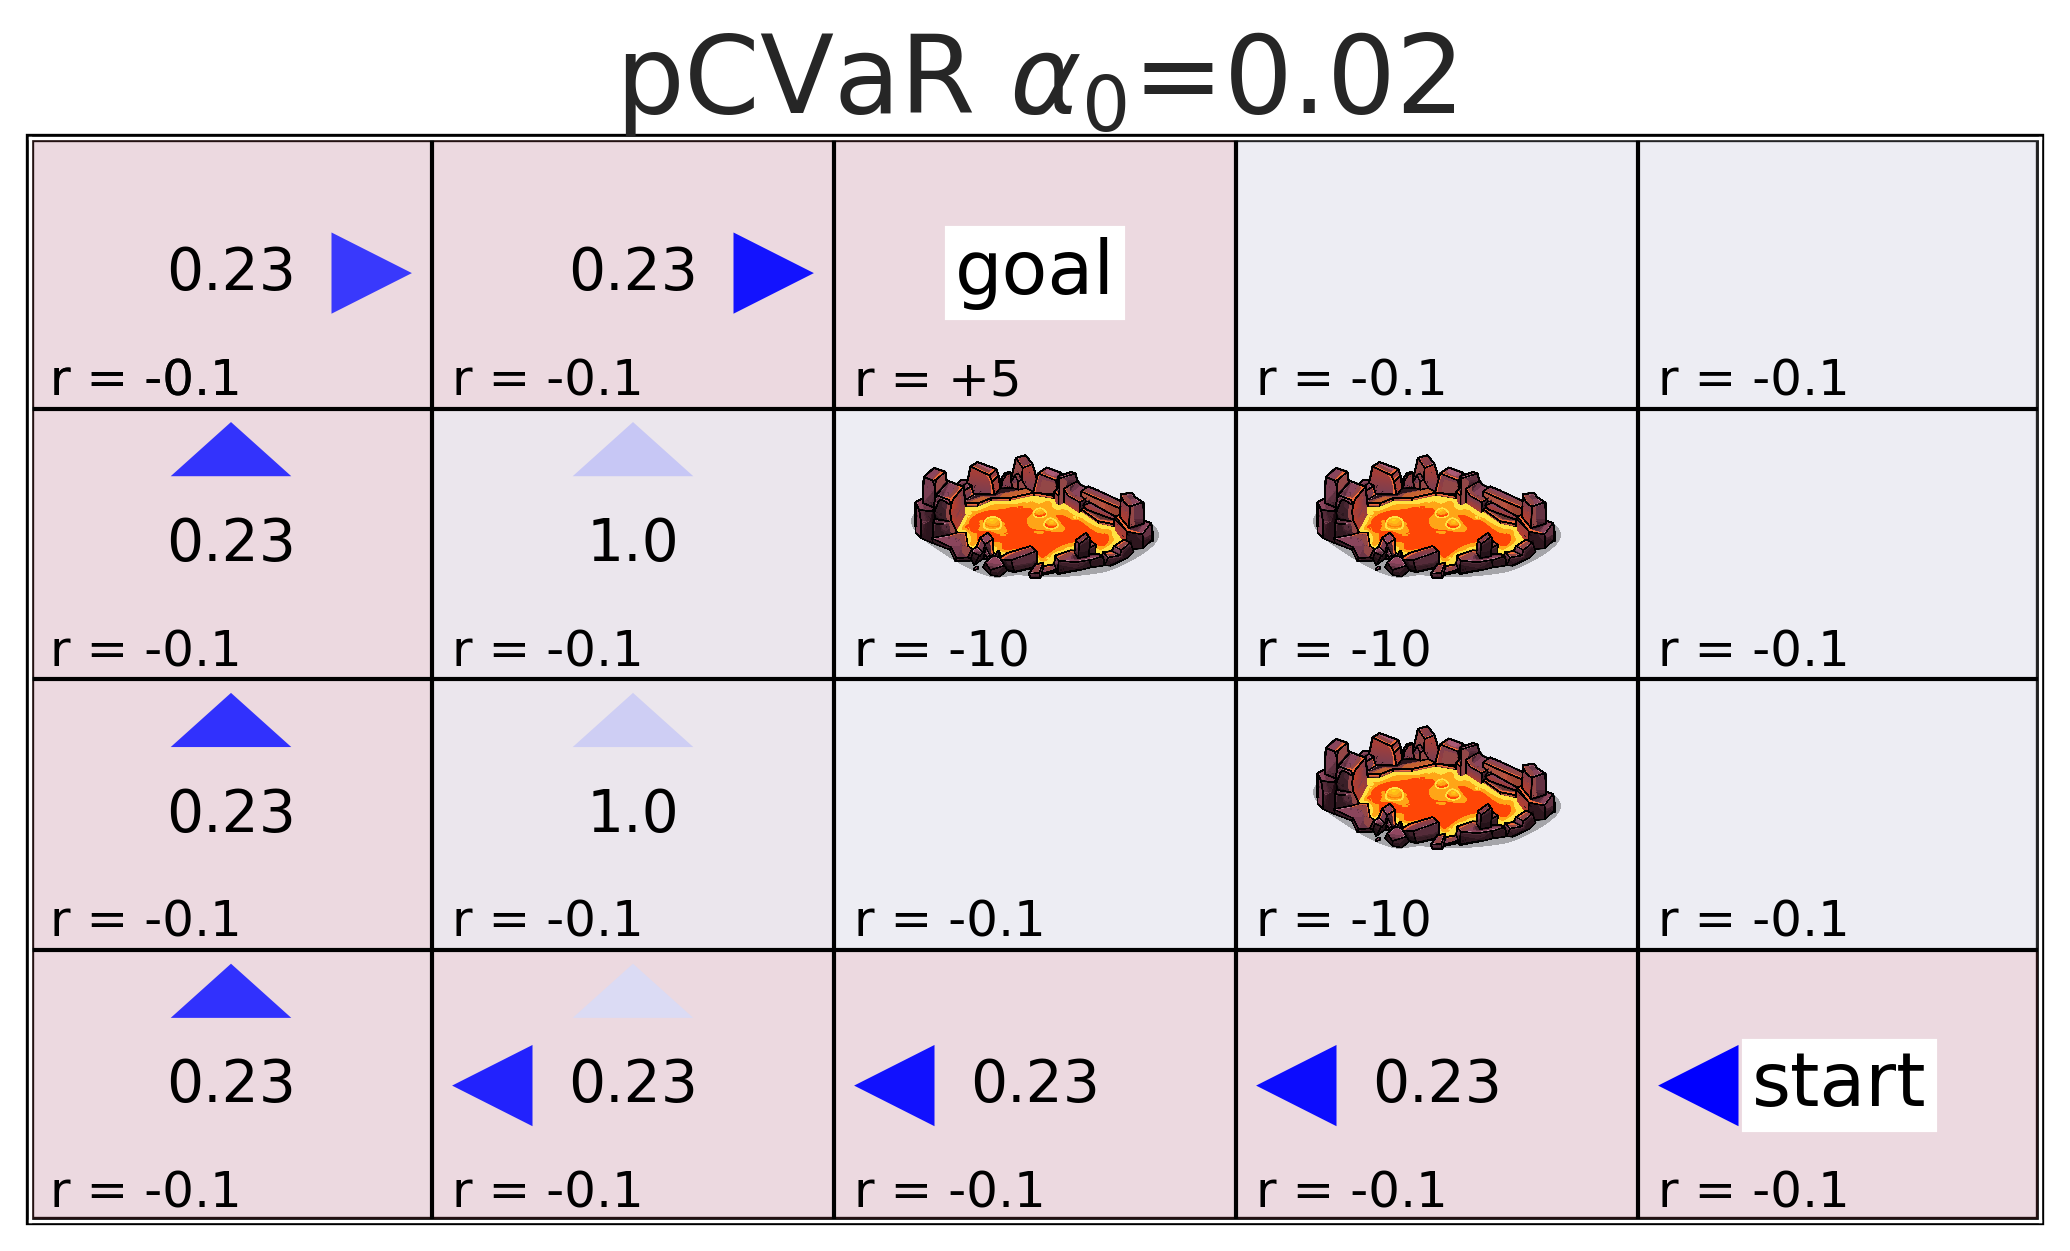

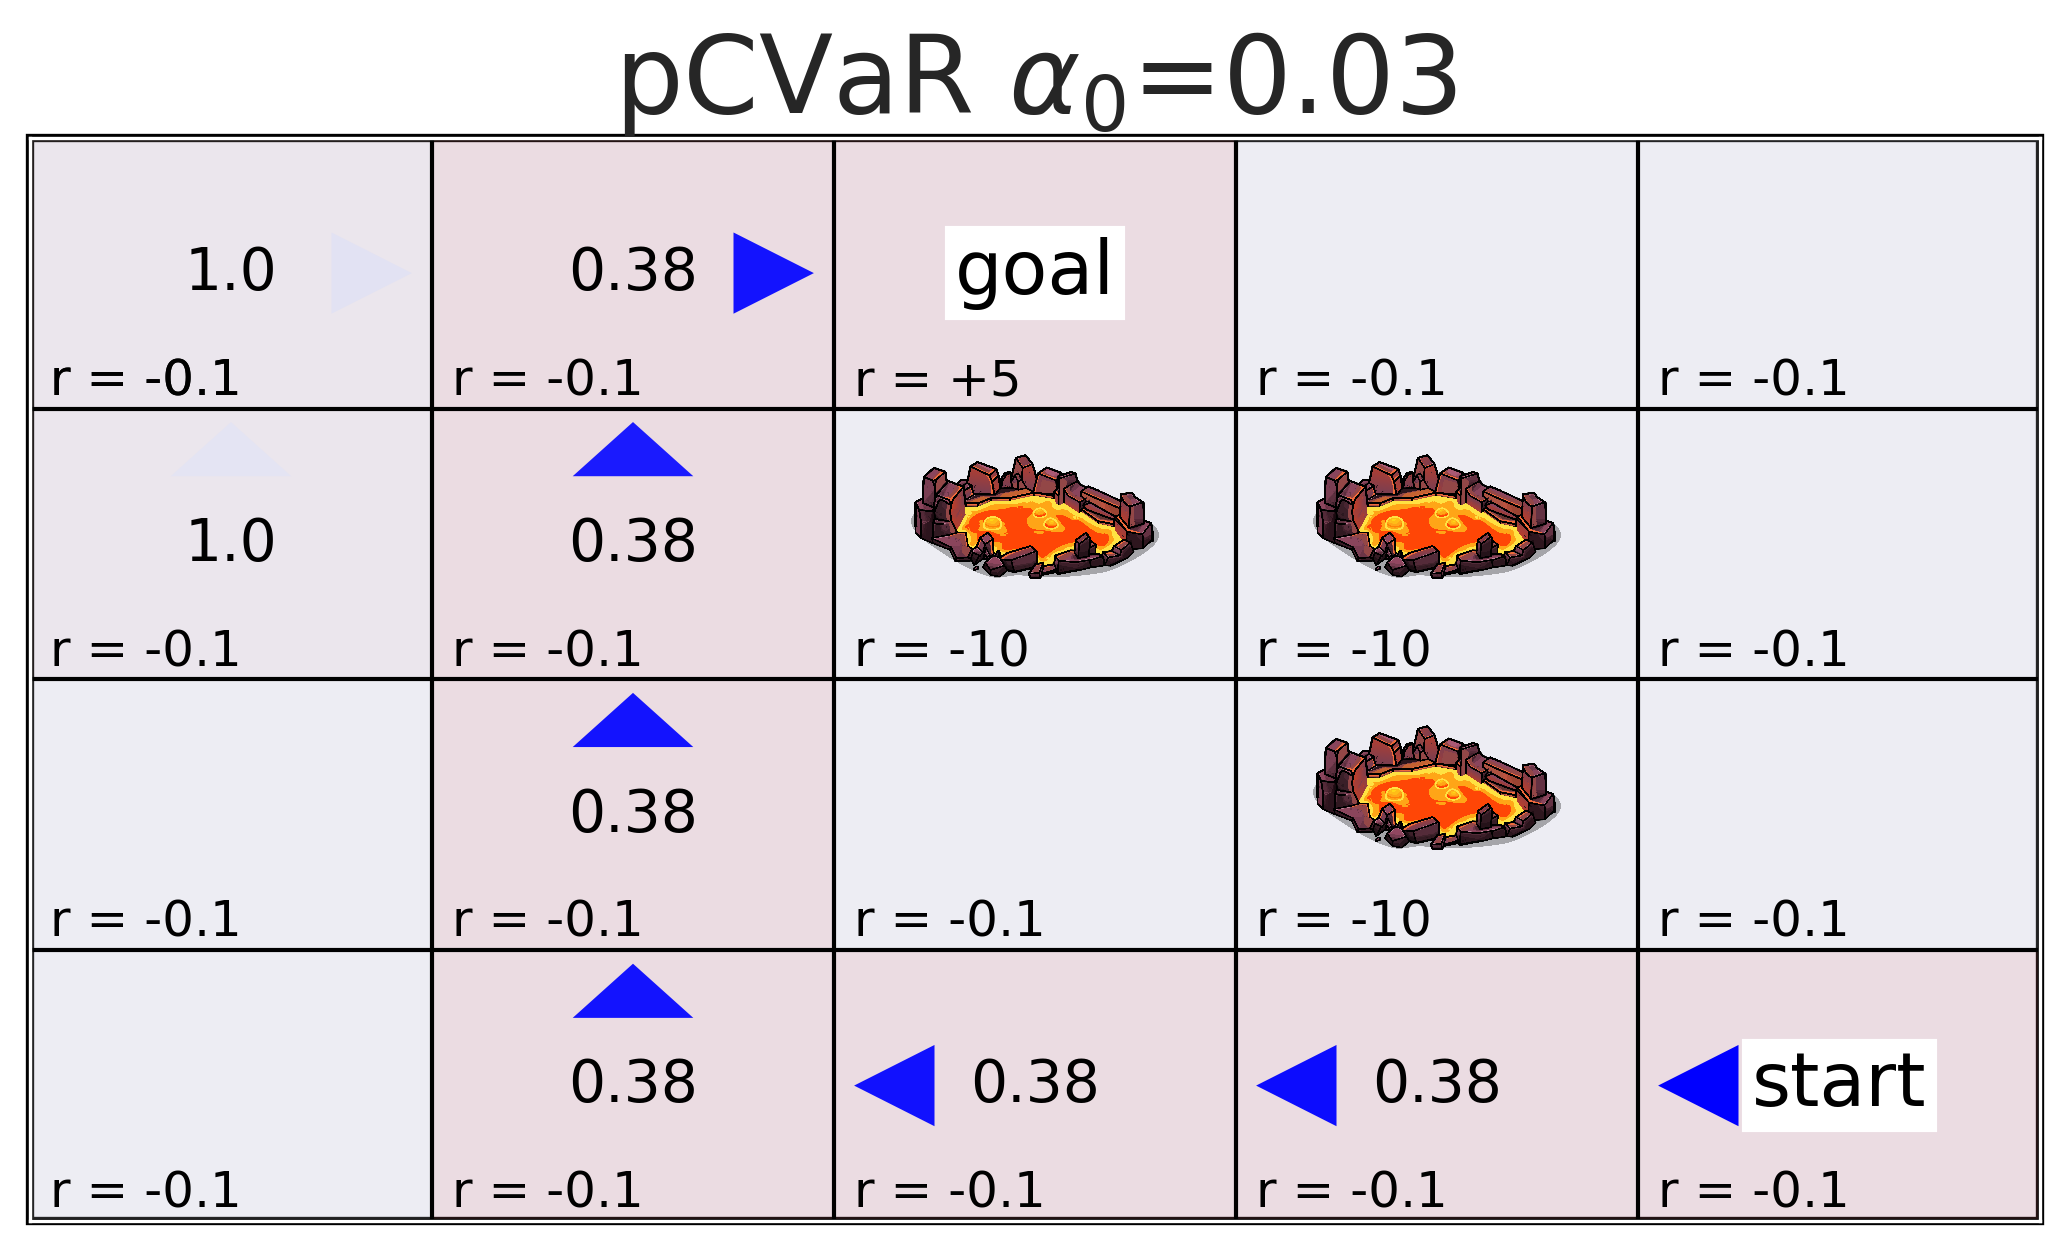

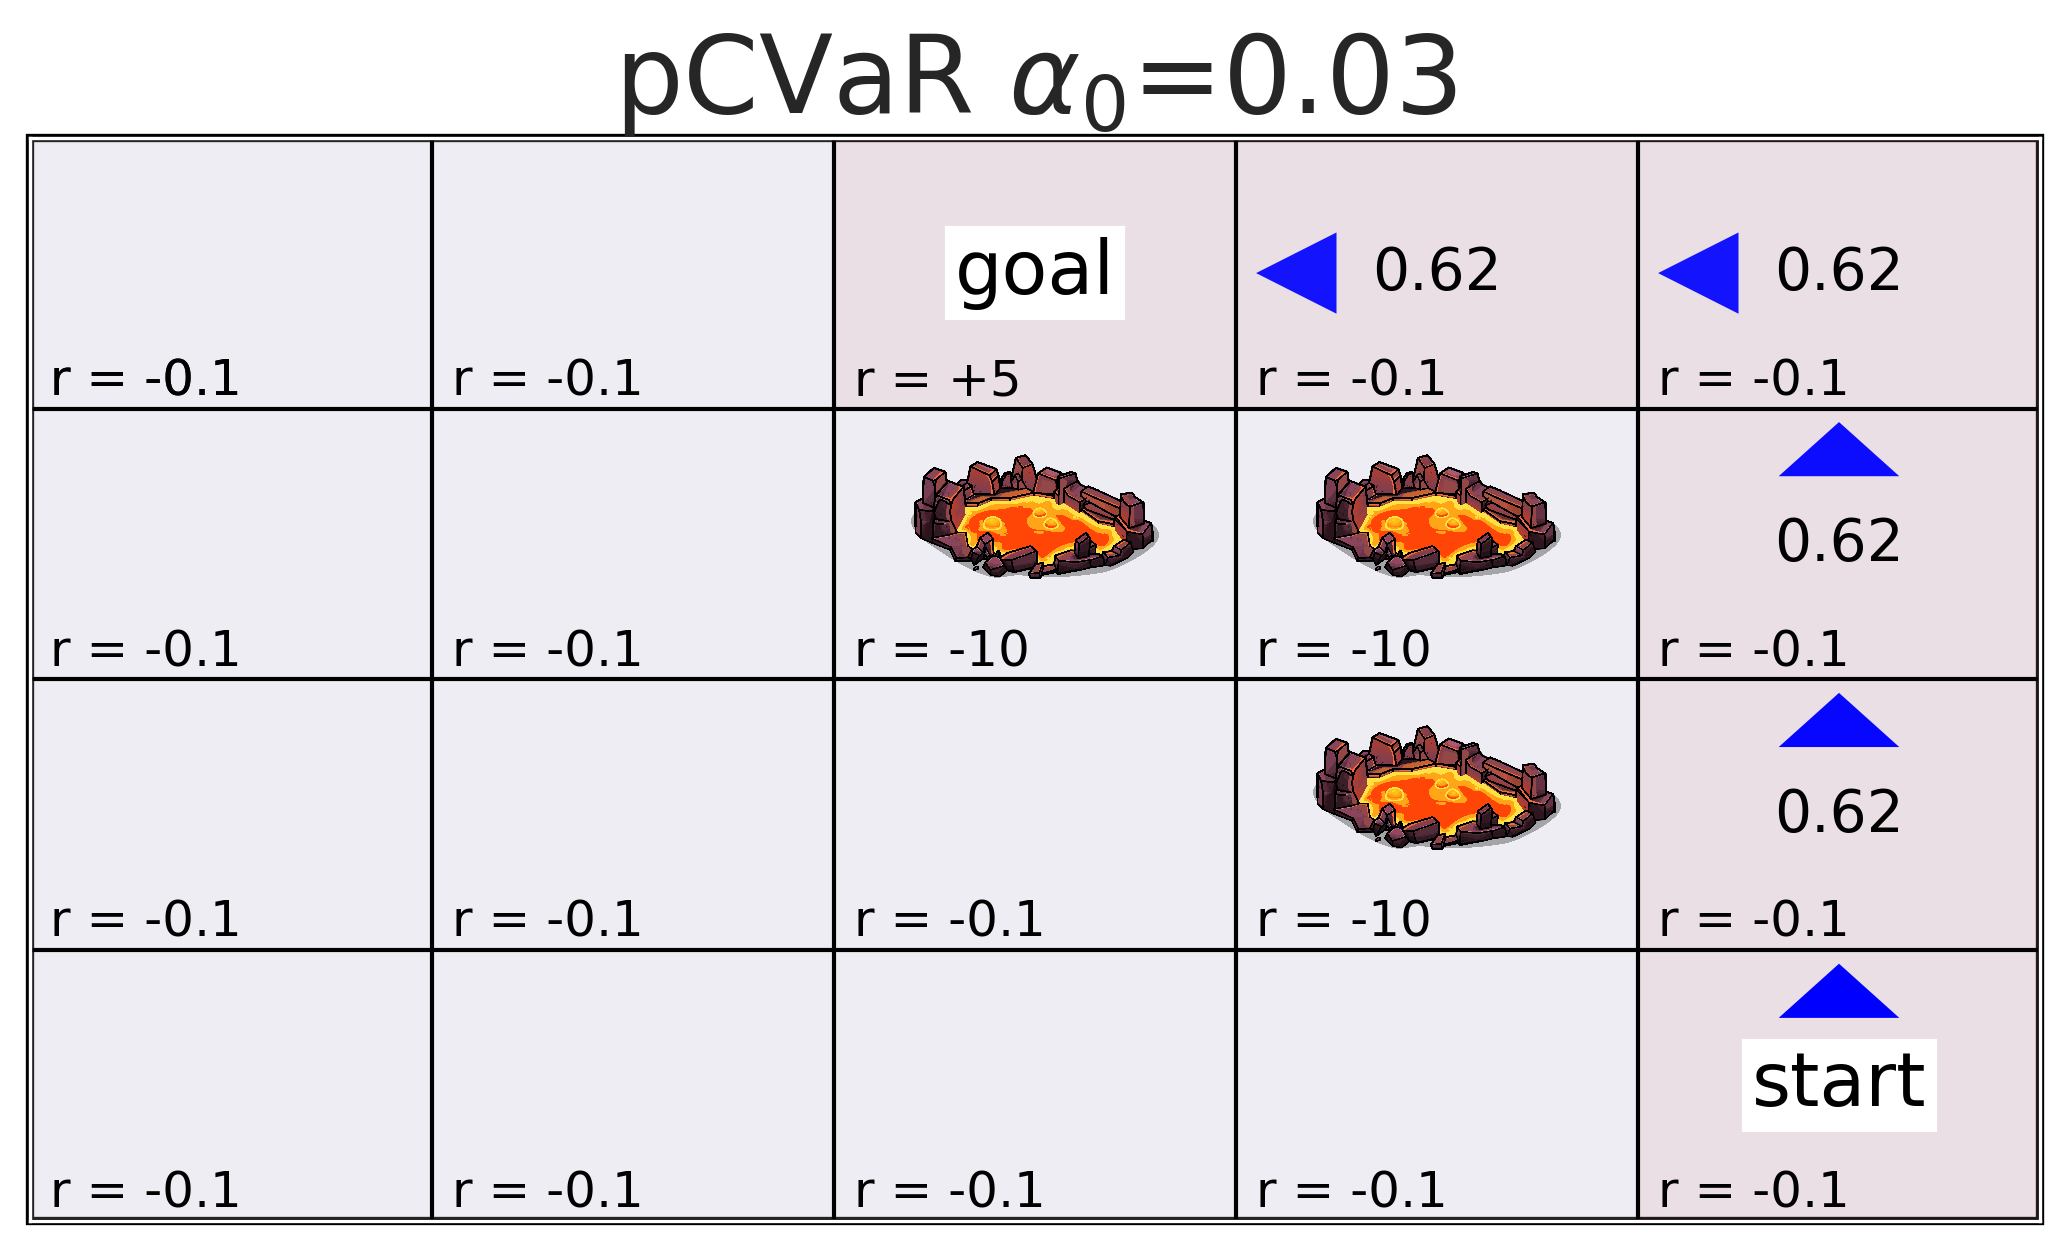

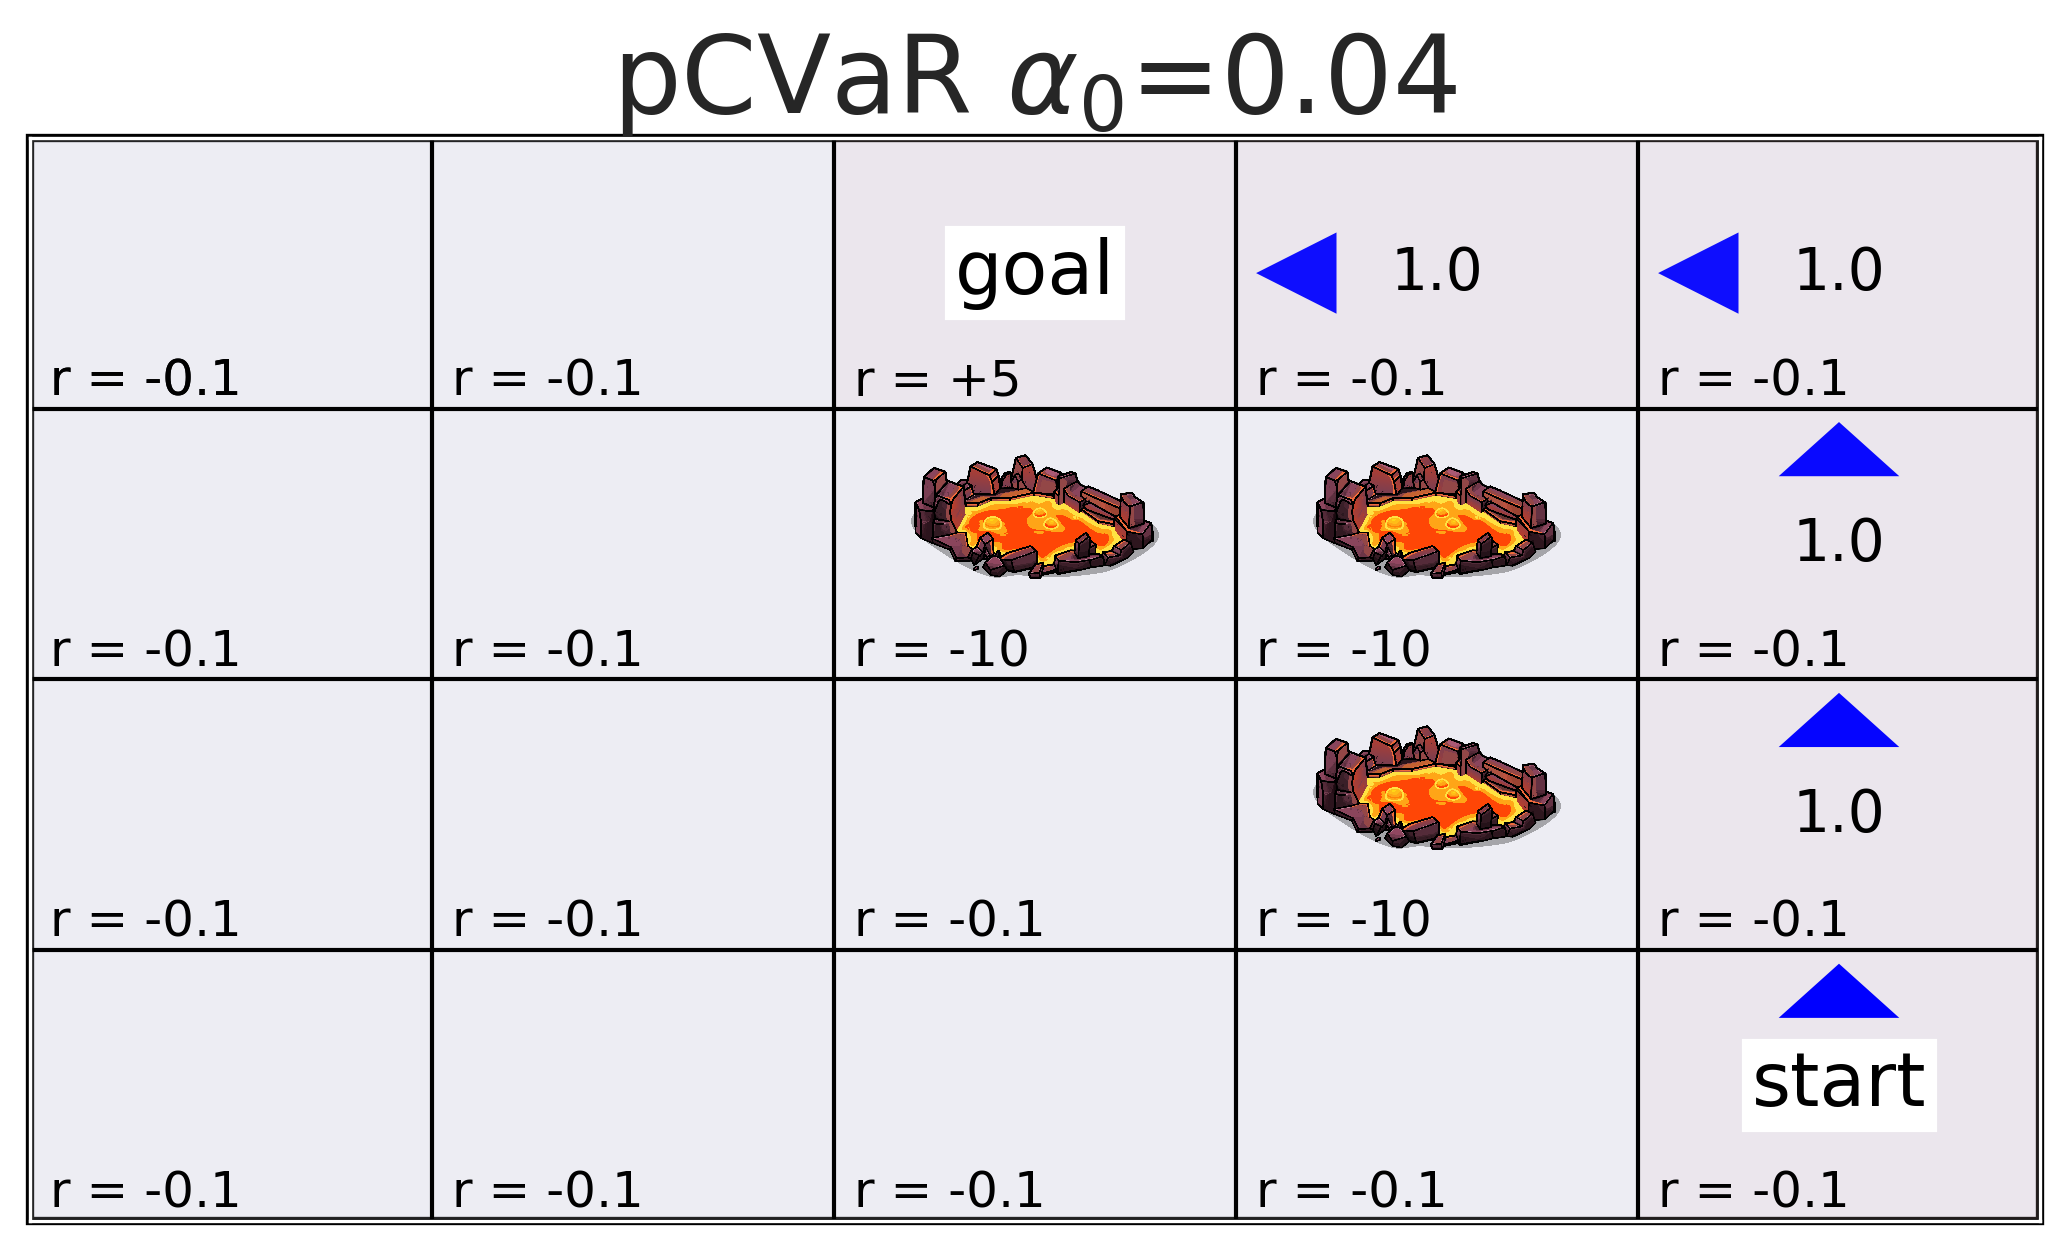

In [13]:
plot_task(task=task_3, task_name='task_3', alpha_set=alpha_set, alpha0_set=alpha0_set, model_names=['pCVaR'])